# Group project - DATA201

> By Oscar Toohey, Jamie Barnes, Seth Gunn, Bach Vu, Angus Loader


# How COVID affect living price in New Zealand

## Data Source (dir `data/`):
| Location | Content | URL |
|----|----|----|
| `household.csv` | CPI |  |
| `Overseas.csv`| Import/Export by tonnes |  |
| `Number_of_covid.csv` | Covid statistic by Health Ministry |  |

### R libraries

In [35]:
library(tidyverse)
library(rvest)
library(magrittr) # better handling of pipes

library(purrr) # to work with lists and map functions
library(glue)
library(stringr) # to handle string conversion

# install.packages("zoo") # as.yearqtr
# install.packages("skim")
library(zoo)
library(skimr)

library(ggplot2)

### Covid stats


**Reading the CSV into a variable**

In [36]:
covid_case_df <- read_csv("data/Number_of_cases.csv")

covid_case_df %>% glimpse()

New names:
* `` -> ...1

Rows: 1554 Columns: 18

-- Column specification --------------------------------------------------------
Delimiter: ","
chr  (13): ResourceID, Subject, Title, Description, Source, SourceURL, Frequ...
dbl   (3): ...1, Value, Multiplier
dttm  (1): Modified
date  (1): Period


i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.



Rows: 1,554
Columns: 18
$ ...1        <dbl> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,~
$ ResourceID  <chr> "CPCOV2", "CPCOV2", "CPCOV2", "CPCOV2", "CPCOV2", "CPCOV2"~
$ Subject     <chr> "COVID-19", "COVID-19", "COVID-19", "COVID-19", "COVID-19"~
$ Title       <chr> "Number of Cases", "Number of Cases", "Number of Cases", "~
$ Description <chr> "COVID-19 cases in New Zealand (cumulative)", "COVID-19 ca~
$ Source      <chr> "Ministry of Health", "Ministry of Health", "Ministry of H~
$ SourceURL   <chr> "https://www.health.govt.nz/our-work/diseases-and-conditio~
$ Modified    <dttm> 2021-10-06 11:00:00, 2021-10-06 11:00:00, 2021-10-06 11:0~
$ Frequency   <chr> "Daily", "Daily", "Daily", "Daily", "Daily", "Daily", "Dai~
$ Var1        <chr> "Case status", "Case status", "Case status", "Case status"~
$ id          <chr> "3934f4da-e3ed-43c4-8656-441f49f9c7ca", "2a4fa96a-27a1-423~
$ Period      <date> 2020-02-28, 2020-02-29, 2020-03-01, 2020-03-02, 2020-03-0~
$ Duration    <c

**Creating helpers**

In [62]:
convertToWeek <- function(date, format="%V-%Y") {
    return (strftime(date, format=format))
}

getFirstDayOfWeek <- function(date) {
    weekIndex = strtoi(convertToWeek(date, format="%V"), base=10L)
    year = convertToWeek(date, format="%Y")
    string <- paste(year, weekIndex, "1", sep="-") # 1 for Monday
    return (string)
}

getByStatus <- function(data, status, rename=FALSE) {
    result <- data %>% filter(Status==status)
    if (rename == TRUE) {
        result %<>% select(Value, Date) 
        names(result)[names(result) == 'Value'] <- status
    }
    return (result)
}

trim_Covid_Raw_df <-function(covid_df, option) {
    covid_df <- covid_df %>% rename(Status=Label1, Date=Period)
    covid_df %<>% mutate(
        Week = map_chr(Date, convertToWeek),
        Monday = map_chr(Date, getFirstDayOfWeek)
    )
    suppressWarnings( # There is not good record in raw data, see Failure in report
        covid_df <- transform(covid_df, Monday=as.Date(Monday, format="%Y-%U-%u"))
    )
    
    if (option == "Status") {
        covid_status_df <- covid_df %>% select(Value, Date, Status) %>%
                                        group_by(Status) %>% summarise()
        return (covid_status_df)        
    }
    
    deceased_covid_case_df <- getByStatus(covid_df, "Deceased", TRUE)
    recovered_covid_case_df <- getByStatus(covid_df, "Recovered", TRUE)
    active_covid_case_df <- getByStatus(covid_df, "Active", TRUE)
    if (option == "Deceased") {
        return (deceased_covid_case_df)
    } else if (option == "Recovered") {
        return (recovered_covid_case_df)
    } else if (option == "Active") {
        return (active_covid_case_df)
    }    
    
    temp <- merge(x = deceased_covid_case_df, y = recovered_covid_case_df, 
                  by = "Date", all = TRUE)
    covid_case_mutated_df <- merge(x = temp, y = active_covid_case_df, 
                                   by = "Date", all = TRUE) # Outer join
    if (option == "Sample") {        
        newdata <- covid_case_mutated_df %>% sample_n(10)
        return (newdata[order(newdata$Date),])
    } else if (option == "Summary") {
        return (covid_case_mutated_df) # Trim unecessary cols
    }
    
    return (covid_df)
}

PLOT_SIZE <- c(14, 10) # in inches
options(repr.plot.width = PLOT_SIZE[1], repr.plot.height = PLOT_SIZE[2]) # Size of graph display
savePlot <- function(filename, df_plot) {
    ggsave(paste("img", filename, sep="/"), plot = df_plot,
           width = 14, height = 10, 
           dpi = 300, units = "in", device='png')
}

**Explore data**

In [38]:
# Test
trim_Covid_Raw_df(covid_case_df, "Status")
trim_Covid_Raw_df(covid_case_df, "Deceased") %>% glimpse()
trim_Covid_Raw_df(covid_case_df, "Recovered") %>% glimpse()
trim_Covid_Raw_df(covid_case_df, "Active") %>% glimpse()
trim_Covid_Raw_df(covid_case_df, "Sample")
trim_Covid_Raw_df(covid_case_df, "Summary") %>% glimpse()

Status
<chr>
Active
Deceased
Recovered


Rows: 518
Columns: 2
$ Deceased <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0~
$ Date     <date> 2020-02-28, 2020-02-29, 2020-03-01, 2020-03-02, 2020-03-05, ~
Rows: 518
Columns: 2
$ Recovered <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ~
$ Date      <date> 2020-02-28, 2020-03-01, 2020-02-29, 2020-03-03, 2020-03-02,~
Rows: 518
Columns: 2
$ Active <dbl> 1, 1, 1, 1, 1, 3, 3, 4, 5, 5, 5, 5, 5, 5, 6, 5, 8, 8, 12, 20, 2~
$ Date   <date> 2020-02-28, 2020-03-01, 2020-03-02, 2020-03-03, 2020-02-29, 20~


,Date,Deceased,Recovered,Active
,<date>,<dbl>,<dbl>,<dbl>
8,2020-04-11,4,422,886
2,2020-08-11,22,1526,22
7,2020-08-15,22,1531,56
10,2020-08-19,22,1531,96
5,2020-08-22,22,1538,111
1,2020-08-31,22,1585,131
6,2020-11-19,25,1948,37
9,2020-12-20,25,2036,55
4,2021-02-09,25,2230,67


Rows: 518
Columns: 4
$ Date      <date> 2020-02-28, 2020-02-29, 2020-03-01, 2020-03-02, 2020-03-03,~
$ Deceased  <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ~
$ Recovered <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ~
$ Active    <dbl> 1, 1, 1, 1, 1, 3, 3, 4, 5, 5, 5, 5, 5, 5, 5, 6, 8, 8, 12, 20~


In [39]:
# write.csv(trim_Covid_Raw_df(covid_case_df, "Summary"), "data/Wrangled_Covid.csv")

**Wrangle data and graphing**

In [40]:
# Source: http://rstudio-pubs-static.s3.amazonaws.com/3256_bb10db1440724dac8fa40da5e658ada5.html
color <- c(rgb(1,0,0.4,1), rgb(0,1,0.4,1), rgb(0,0,1,1))
graph_df <- trim_Covid_Raw_df(covid_case_df, "")
graph_week_df <- graph_df %>%
    group_by(Monday, Status, Week) %>%
    summarise(Value = mean(Value))

`summarise()` has grouped output by 'Monday', 'Status'. You can override using the `.groups` argument.



In [41]:
new_case_plot <- ggplot(data = getByStatus(graph_df, "Active"), 
               aes(x=Date, y=Value)
        ) +
        geom_line(colour=color[1], size=2) +
        scale_color_manual(values=color) + theme_bw() +
        theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
        scale_x_date(date_breaks = "months" , date_labels = "%b-%y")

new_case_plot <- new_case_plot +
ggtitle("New case by Week") +
ylab("Total cases") + xlab("Month")

In [42]:
graph_week_df$Status <- factor(graph_week_df$Status, 
                               levels = c("Active", "Recovered", "Deceased"))

covid_weekly_plot <- ggplot() +
        geom_bar(stat='identity', data = graph_week_df,
                aes(x=Monday, y=Value, fill=factor(Status))) +
        geom_line(data=getByStatus(graph_df, "Active"), colour=color[1], size=2,
                 aes(x=Date, y=Value)) +
        scale_color_manual(values=color) + theme_bw() +
        theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
        scale_x_date(date_breaks = "months" , date_labels = "%b-%y")


covid_weekly_plot <- covid_weekly_plot +
ggtitle("Total case affected by Covid Weekly") +
ylab("Total cases") + xlab("Months") +
labs(fill="Status")

Warning message:
"Removed 6 rows containing missing values (position_stack)."


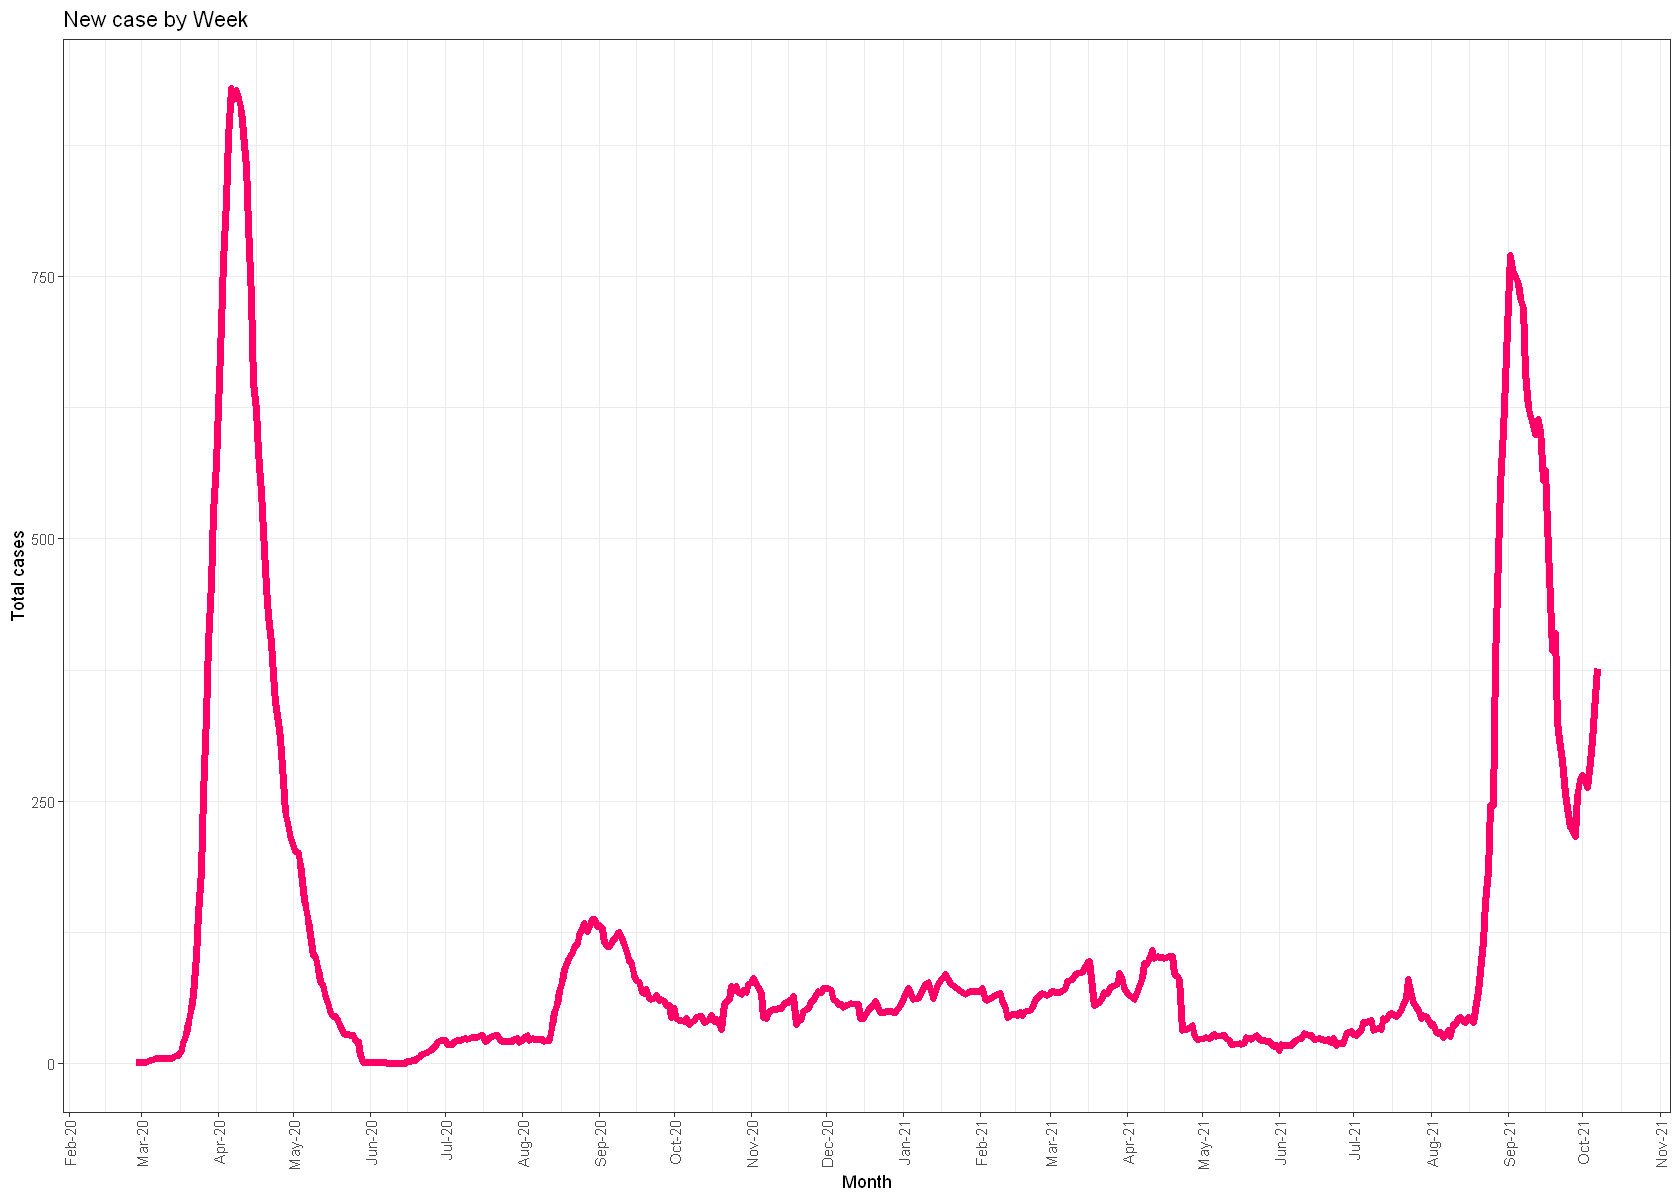

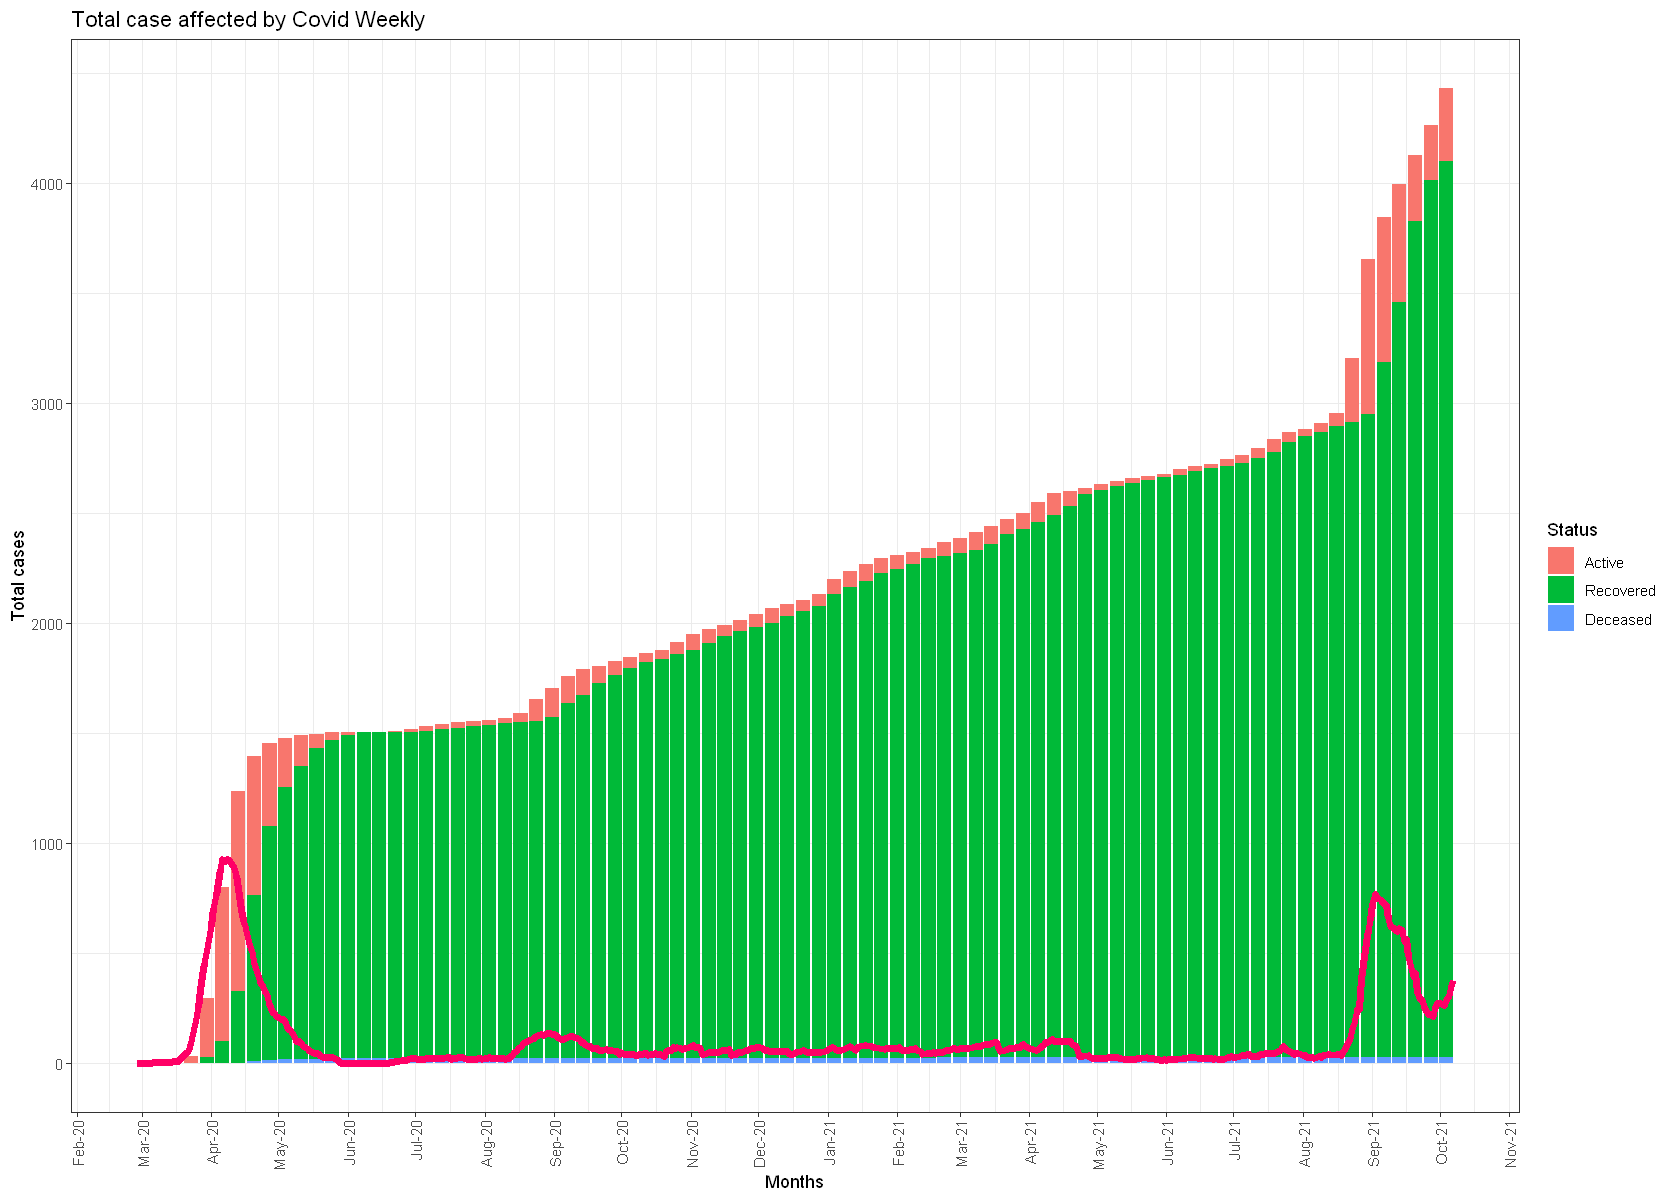

In [43]:
# Show Plots
new_case_plot
covid_weekly_plot

# Save Plots
# savePlot("covid_new_case_weekly.png", new_case_plot)
# savePlot("covid_case_weekly.png", covid_weekly_plot)

### Living household Index (CPI)

**Reading the CSV into a variable**

In [44]:
HH_LC_PI_df <- read_csv(file = "data/household-living-costs-price-indexes-June-2021-quarter-time-series-indexes.csv")
HH_LC_PI_df %>% head()

Rows: 45262 Columns: 11

-- Column specification --------------------------------------------------------
Delimiter: ","
chr (8): hlpi_name, series_ref, quarter, hlpi, nzhec, nzhec_name, nzhec_shor...
dbl (3): index, change.q, change.a


i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.



hlpi_name,series_ref,quarter,hlpi,nzhec,nzhec_name,nzhec_short,level,index,change.q,change.a
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
All households,HPIQ.SALL01,2008Q2,allhh,1,Food,Food,group,870,NA,NA
All households,HPIQ.SALL01,2008Q3,allhh,1,Food,Food,group,903,3.8,NA
All households,HPIQ.SALL01,2008Q4,allhh,1,Food,Food,group,918,1.7,NA
All households,HPIQ.SALL01,2009Q1,allhh,1,Food,Food,group,927,1.0,NA
All households,HPIQ.SALL01,2009Q2,allhh,1,Food,Food,group,935,0.9,7.5
All households,HPIQ.SALL01,2009Q3,allhh,1,Food,Food,group,949,1.5,5.1


**Wrangling data for all households and the groups we are interested in.**

In [45]:
interested_groups <- c("Petrol", "Food", "All groups")
CPI_PRF <- HH_LC_PI_df %>% 
    filter(hlpi_name == "All households", 
        (nzhec_name %in% interested_groups) | (nzhec_short == "Rent" & level == "subgroup")
    ) %>%
    select(quarter, nzhec_short, index) %>%
    spread(key = nzhec_short, value = index)
CPI_PRF %>% head()

# Write to csv
# write.csv(CPI_PRF, "data/Wrangled_CPI.csv")

quarter,All groups,Food,Petrol,Rent
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
2008Q2,898,870,915,895
2008Q3,911,903,957,902
2008Q4,906,918,743,906
2009Q1,903,927,736,908
2009Q2,905,935,760,910
2009Q3,914,949,775,912


**Plotting**

In [46]:
cpi_plot <- CPI_PRF %>%
    gather(key = group, value = index, -quarter) %>%
    arrange(quarter) %>%
    mutate(quarter = as.Date(as.yearqtr(quarter, format = "%YQ%q"), frac = 1)) %>%
    ggplot(mapping = aes(x = quarter, y = index, group = group, colour = group)) +
    scale_colour_discrete("Group") + ggtitle("Quarterly CPI for Different Groups Over Time") +
    ylab("Index") + xlab("Quarter") + geom_line(lwd=1.5) +
    geom_line()

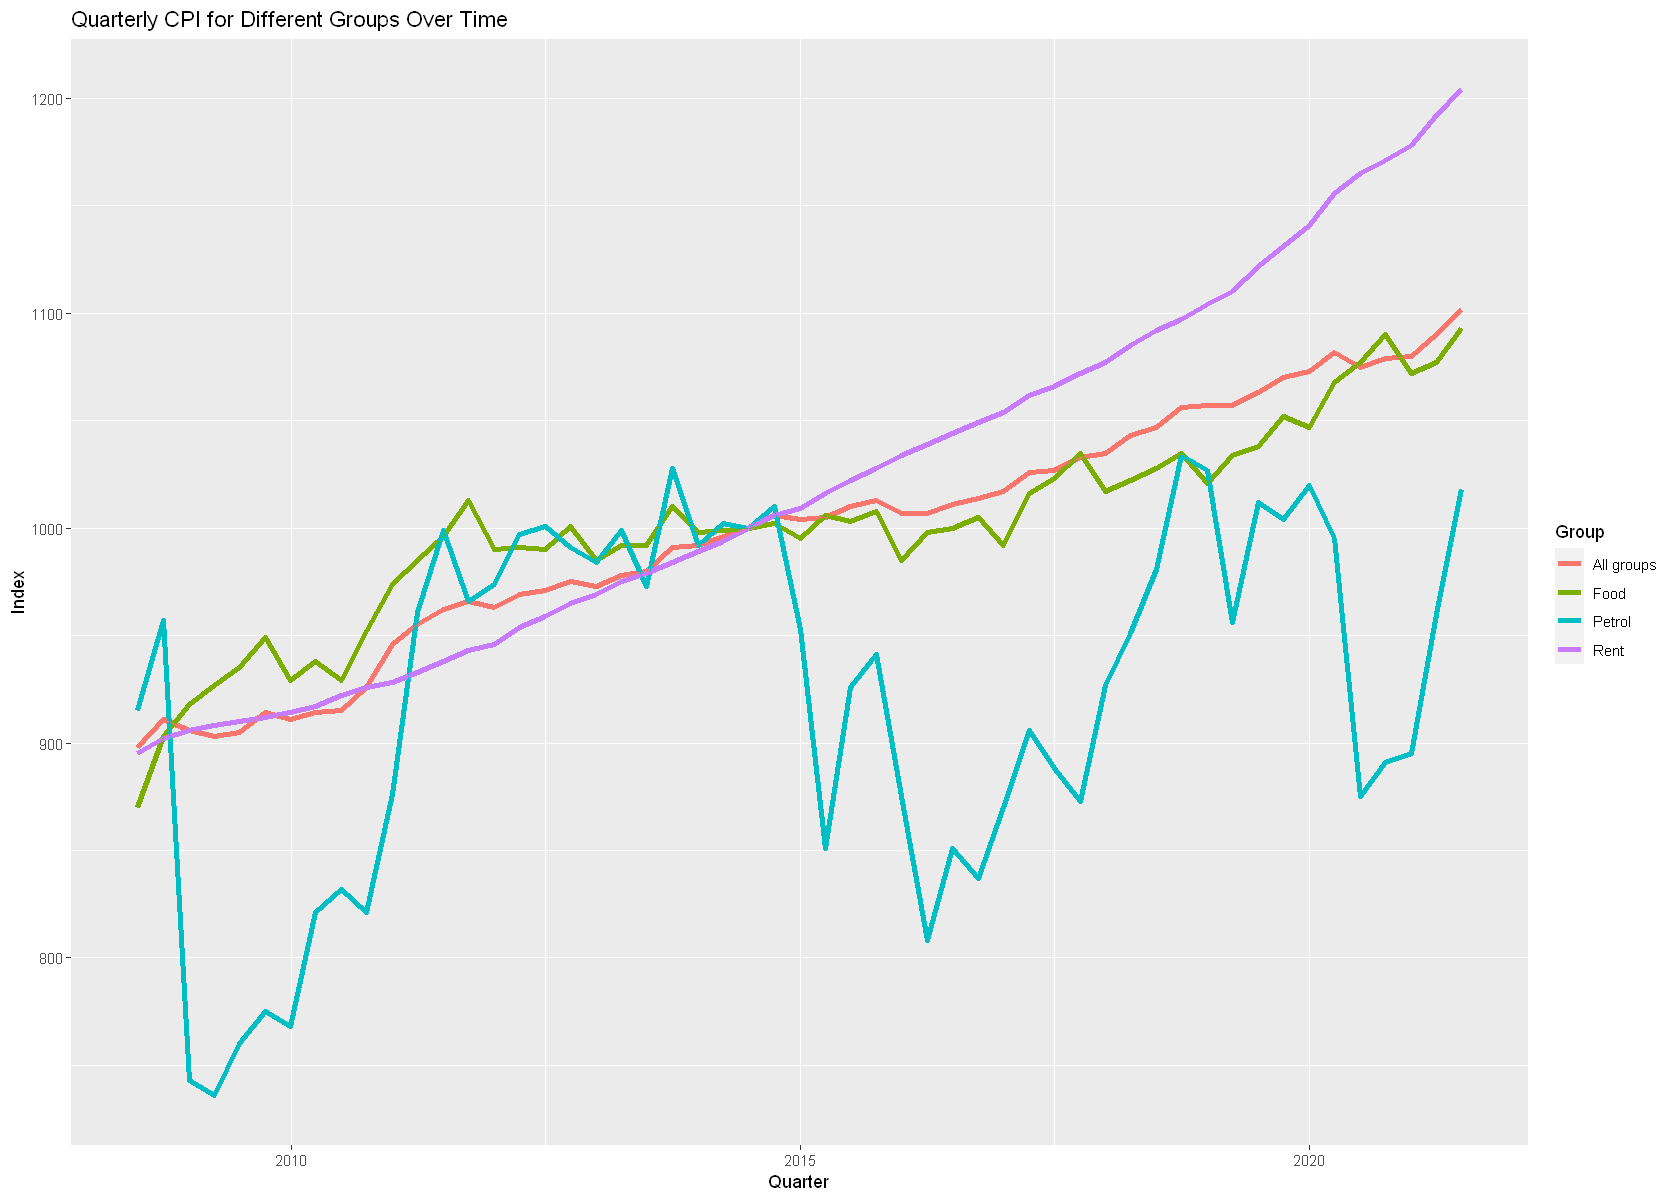

In [47]:
# Show Plot
cpi_plot

# Save Plot
# savePlot("CPI_plot.png", cpi_plot)

### Import/Export factors

**Reading the CSV into a variable**

In [48]:
os_c_df <- read_csv("data/Overseas_Cargo_dataset.csv")
os_c_df %>% glimpse()

New names:
* `` -> ...1

Rows: 39592 Columns: 25

-- Column specification --------------------------------------------------------
Delimiter: ","
chr  (20): ResourceID, Subject, Title, Description, Notes, Caveats, Source, ...
dbl   (3): ...1, Value, Multiplier
dttm  (1): Modified
date  (1): Period


i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.



Rows: 39,592
Columns: 25
$ ...1        <dbl> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,~
$ ResourceID  <chr> "OSC1.1", "OSC1.1", "OSC1.1", "OSC1.1", "OSC1.1", "OSC1.1"~
$ Subject     <chr> "Overseas Cargo Statistics", "Overseas Cargo Statistics", ~
$ Title       <chr> "Overseas cargo exports and imports by New Zealand port", ~
$ Description <chr> "Overseas cargo records all goods, value and gross weight,~
$ Notes       <chr> "These figures will differ from those of merchandise trade~
$ Caveats     <chr> "Overseas trade and cargo data is provided by exporters/im~
$ Source      <chr> "Stats NZ", "Stats NZ", "Stats NZ", "Stats NZ", "Stats NZ"~
$ SourceURL   <chr> "www.stats.govt.nz", "www.stats.govt.nz", "www.stats.govt.~
$ Modified    <dttm> 2021-09-23 22:45:00, 2021-09-23 22:45:00, 2021-09-23 22:4~
$ Frequency   <chr> "Monthly", "Monthly", "Monthly", "Monthly", "Monthly", "Mo~
$ Var1        <chr> "Trade Class", "Trade Class", "Trade Class", "Trade Class"~
$ Var2        <

**Wrangling data for all locations and only final measures**

In [49]:
trade_df <- os_c_df %>%
    filter(
        Label2 == "Total All Cargo", 
        Status == "F"
    ) %>% 
    select(Period, Label1, Measure, Value) %>%
    mutate(Measure = ifelse(Measure != "Gross weight value", "NZD_Value_mil", "Gross_Weight_kt"), 
           Value = Value / 1000) %>%
    spread(key=Measure, value=Value) %>%
    rename(Trade = Label1) %>%
    arrange(Period, Trade)
trade_df %>% head()

# Write to csv
# write.csv(trade_df, "data/Wrangled_trade.csv")

Period,Trade,Gross_Weight_kt,NZD_Value_mil
<date>,<chr>,<dbl>,<dbl>
1988-01-31,Exports,550.458,799.476
1988-01-31,Imports,794.129,892.909
1988-02-29,Exports,906.514,1140.441
1988-02-29,Imports,726.047,940.189
1988-03-31,Exports,971.862,1236.020
1988-03-31,Imports,516.128,883.951


**Splitting the data into separate dataframes and creating a function to merge them.**

In [50]:
ImpExp_Value_df <- trade_df %>% 
    select(Period, Trade, NZD_Value_mil) %>%
    spread(key=Trade, value=NZD_Value_mil) %>%
    arrange(Period)

ImpExp_Weight_df <- trade_df %>% 
    select(Period, Trade, Gross_Weight_kt) %>%
    spread(key=Trade, value=Gross_Weight_kt) %>%
    arrange(Period)

merge_ImpExp_df <- function(ImpExp_Weight, ImpExp_Value) {
    ImpExp_df <- merge(x = ImpExp_Weight, y = ImpExp_Value, by = "Period")
    ImpExp_df %<>% rename(Export_weight=Exports.x, Export_value=Exports.y,
                        Import_weight=Imports.x, Import_value=Imports.y)
    return (ImpExp_df)
}
merge_ImpExp_df(ImpExp_Weight_df, ImpExp_Value_df) %>% tail()

,Period,Export_weight,Import_weight,Export_value,Import_value
,<date>,<dbl>,<dbl>,<dbl>,<dbl>
396,2020-12-31,3774.384,1933.317,5621.920,5453.775
397,2021-01-31,2787.226,2169.879,4342.260,5286.249
398,2021-02-28,3544.513,1619.116,4616.824,4374.333
399,2021-03-31,4080.263,2127.964,5926.991,6008.548
400,2021-04-30,4112.935,1866.328,5585.766,5164.883
401,2021-05-31,3656.230,2086.383,6281.892,5965.387


**Plotting Import Export Value and Weight**

In [51]:
startDate = as.Date("2019-10-01")
ImpExp_Value_plot <- ImpExp_Value_df %>% filter(Period > startDate) %>%
    gather(key=trade, value=value, -Period) %>%
    group_by(trade) %>%
    mutate(RA_Value = rollmean(value, k=8, fill=NA)) %>%
    ggplot(mapping = aes(x = Period, y = RA_Value, colour = trade)) + geom_line(lwd=2) +
    ggtitle("Total Monthly Value of Import and Export, rolling 8-month average") +
    ylab("Value (millions NZD)") + xlab("Date") + theme(legend.title = element_blank()) +
    geom_line() +
    scale_x_date(date_breaks = "months" , date_labels = "%b-%y")

ImpExp_Weight_plot <- ImpExp_Weight_df %>% filter(Period > startDate) %>%
    gather(key=ImEx, value=value, -Period) %>%
    group_by(ImEx) %>%
    mutate(RA_Value = rollmean(value, k=8, fill=NA)) %>%
    ggplot(mapping = aes(x = Period, y = RA_Value, colour = ImEx)) + geom_line(lwd=2) +
    ggtitle("Total Monthly Weight of Import and Export, rolling 8-month average") +
    ylab("Weight (thousands of tonnes)") + xlab("Date") + 
    theme(legend.title = element_blank()) +
    geom_line() +
    scale_x_date(date_breaks = "months" , date_labels = "%b-%y")

Warning message:
"Removed 14 row(s) containing missing values (geom_path)."
Warning message:
"Removed 14 row(s) containing missing values (geom_path)."
Warning message:
"Removed 14 row(s) containing missing values (geom_path)."
Warning message:
"Removed 14 row(s) containing missing values (geom_path)."


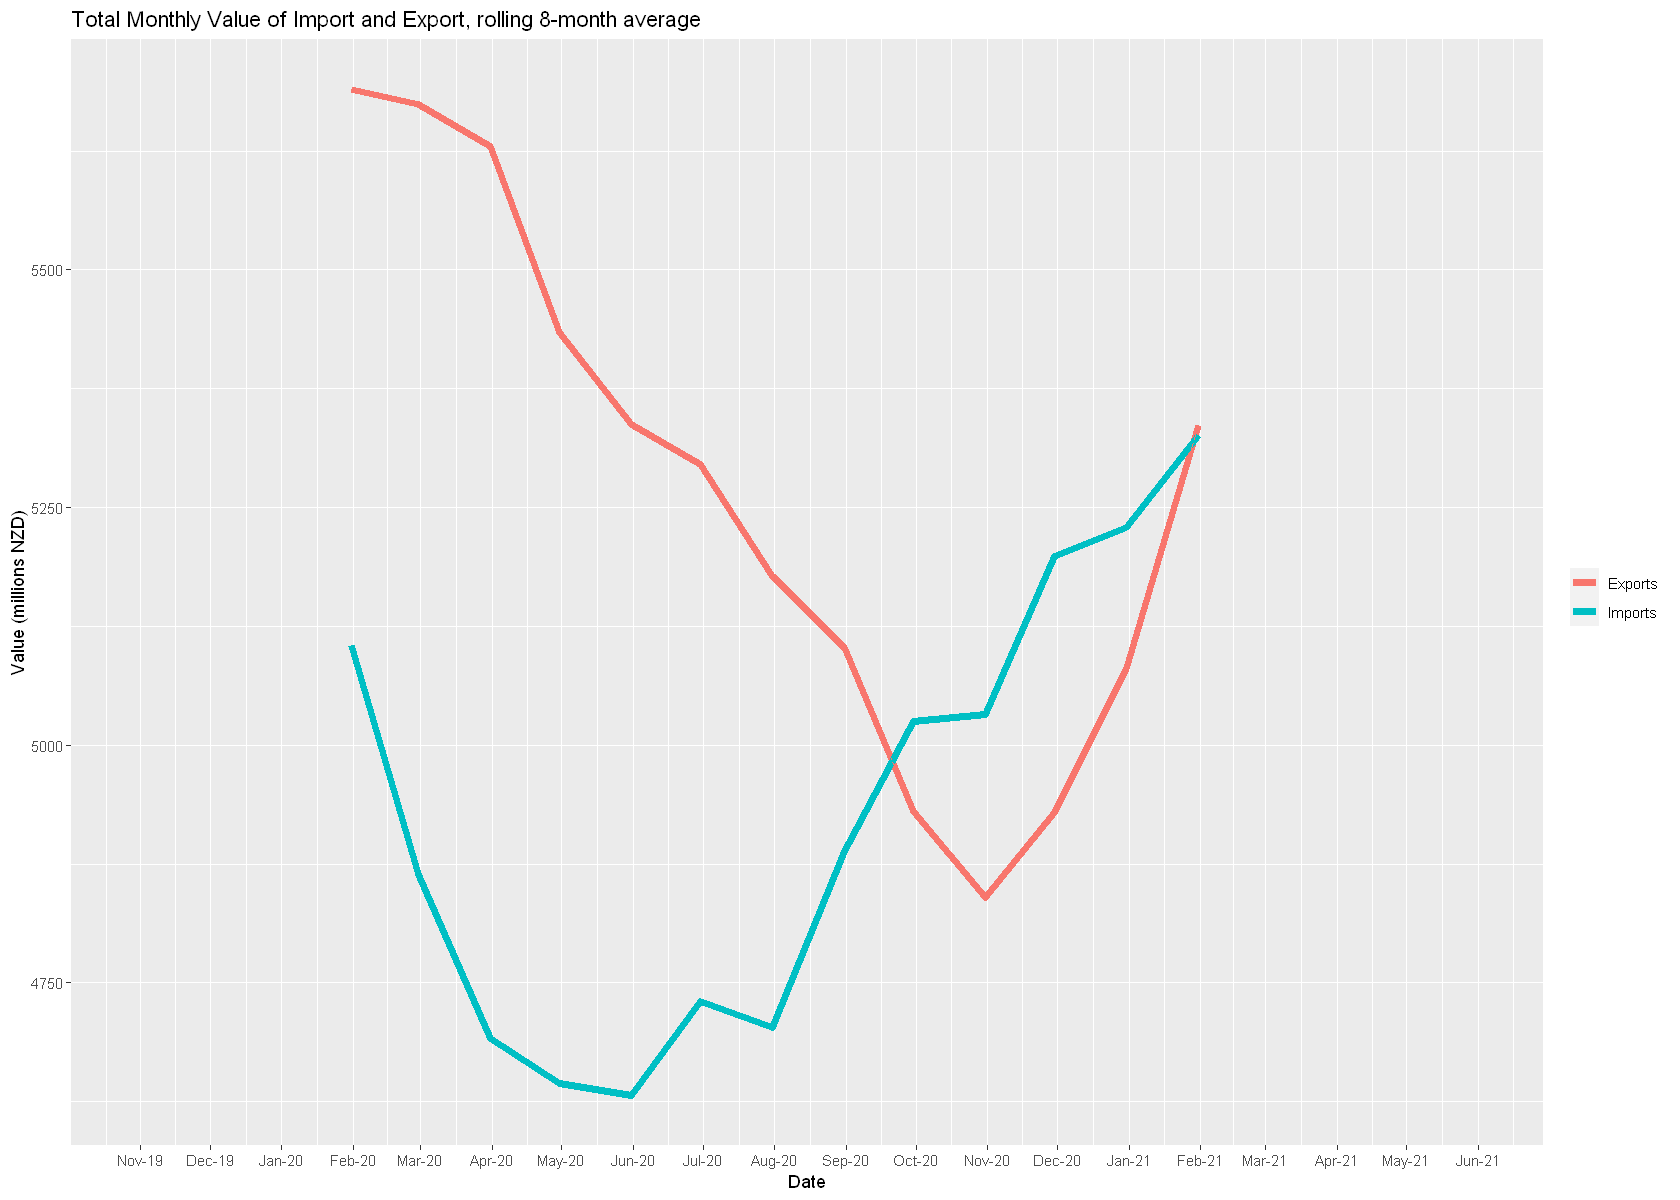

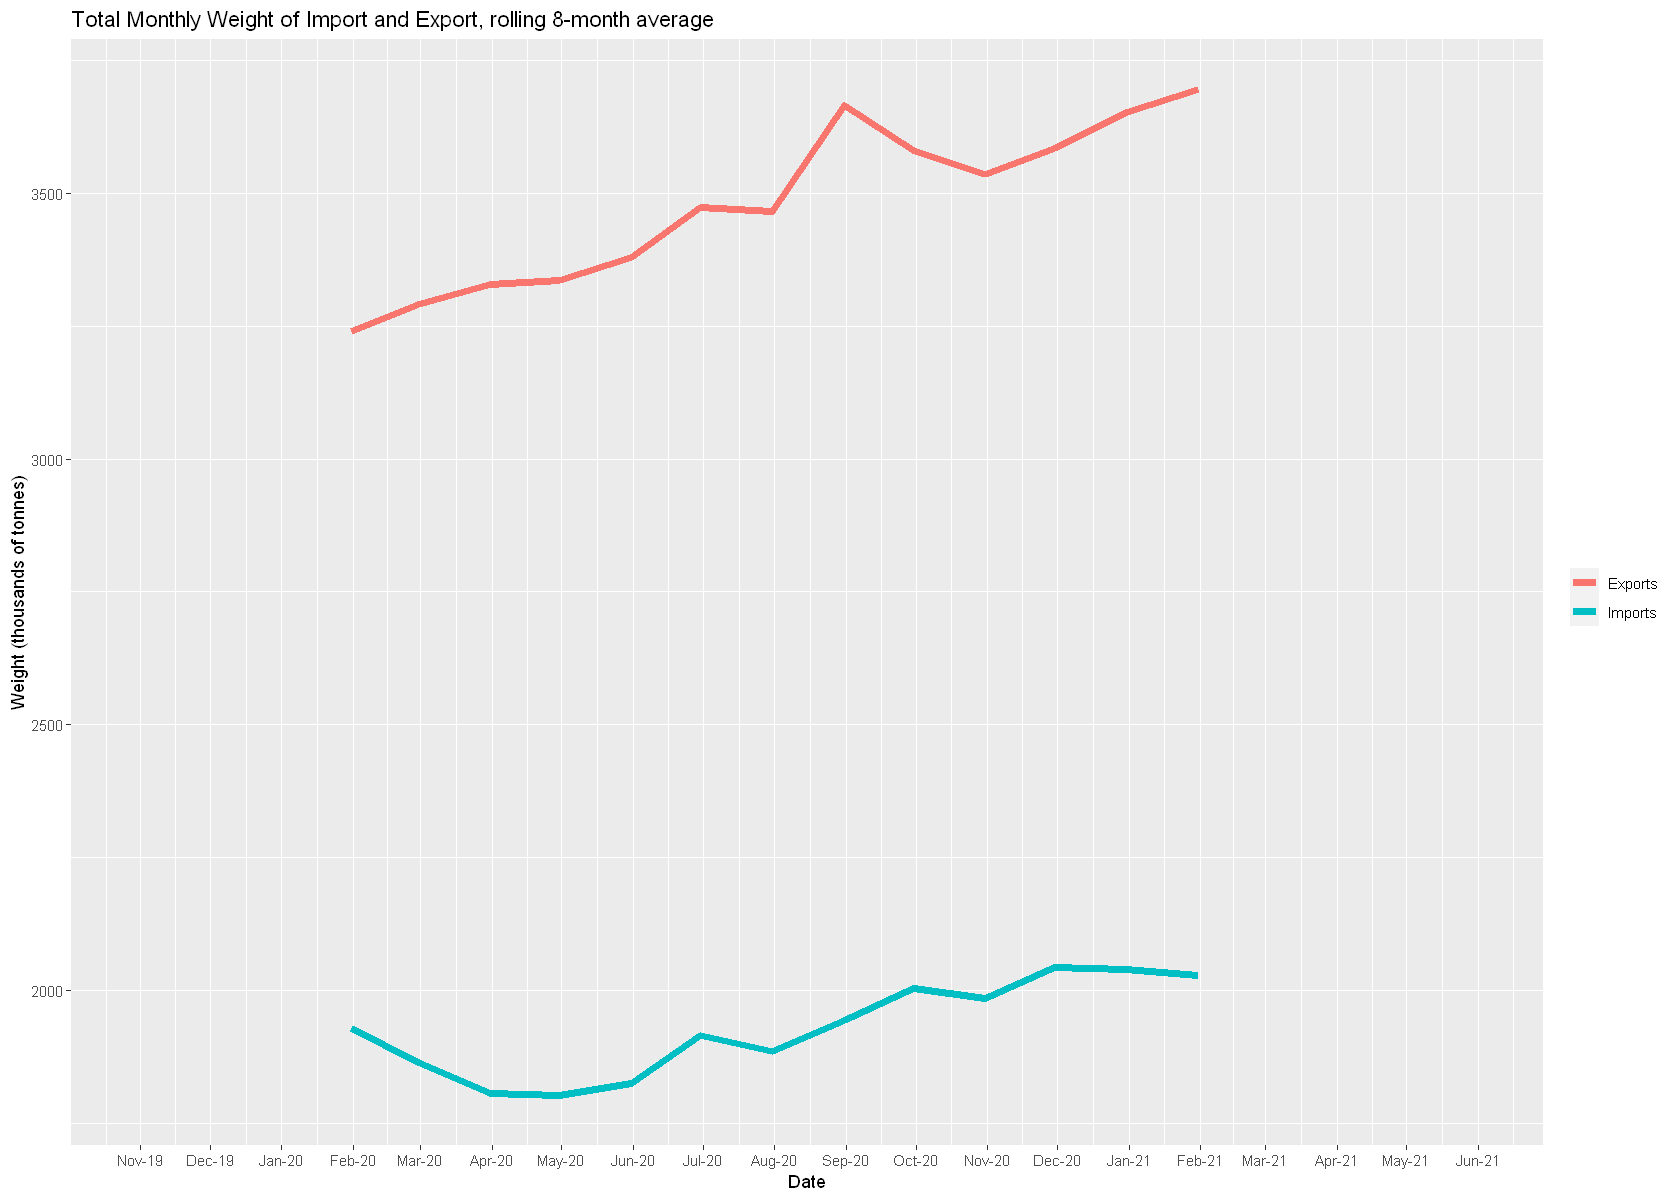

In [52]:
# Show Plots
ImpExp_Value_plot
ImpExp_Weight_plot

# Save Plots
# savePlot("ImpExp_Weight.png", ImpExp_Weight_plot)
# savePlot("ImpExp_Value.png", ImpExp_Value_plot)

## Combine all factors

**Combining each factor's dataframe into a single long dataframe of data from date 2016-01-01.**

In [71]:
temp_cpi_df <- CPI_PRF %>%
    rename(Period=quarter) %>% 
    arrange(Period) %>% 
    mutate(Period = as.Date(as.yearqtr(Period, format = "%YQ%q"), frac = 1))

temp_imp_exp_w_df <- ImpExp_Weight_df %>% rename(Imports_weight_kilotonnes=Imports, Exports_weight_kilotonnes=Exports)

temp_imp_exp_v_df <- ImpExp_Value_df %>% rename(Imports_value_mil_nzd=Imports, Exports_value_mil_nzd=Exports)


startDate = as.Date("2016-01-01")

covid_predictors_df <- full_join(
    trim_Covid_Raw_df(covid_case_df, "Summary"),
    full_join(
        full_join(
        temp_imp_exp_w_df,
        temp_imp_exp_v_df,
        by = "Period",
        all = TRUE
        ),
        temp_cpi_df, 
        by = "Period",
        all = TRUE
    ) %>% rename(Date = Period),
    by = "Date",
    all = TRUE
) %>% 
    gather(key=key, value=value, -Date, na.rm = TRUE) %>% 
    filter(Date > startDate) %>%
    arrange(Date) 
    
covid_predictors_df %>% glimpse()

# Write to csv
# write.csv(covid_predictors_df, "data/Covid_predictors_long.csv")

Rows: 1,902
Columns: 3
$ Date  <date> 2016-01-31, 2016-01-31, 2016-01-31, 2016-01-31, 2016-02-29, 201~
$ key   <chr> "Exports_weight_kilotonnes", "Imports_weight_kilotonnes", "Expor~
$ value <dbl> 2908.427, 1916.587, 3964.305, 3845.692, 3050.787, 1765.095, 4367~


**Setting up dataframes for graphing. Adding 8 month rolling average to import export data.**

In [72]:
startDate = as.Date("2016-01-01")

cpi_2020_df <- CPI_PRF %>%
    gather(key = group, value = index, -quarter) %>%
    rename(Group=group, HPI=index, Quarter=quarter) %>% arrange(Quarter) %>% 
    mutate(Quarter = as.Date(as.yearqtr(Quarter, format = "%YQ%q"), frac = 1)) %>%
    filter(Quarter >= startDate)

ImpExp_Weight_2020_df <- ImpExp_Weight_df %>% filter(Period > startDate) %>%
    gather(key=ImEx, value=value, -Period) %>%
    group_by(ImEx) %>%
    mutate(RA_Value = rollmean(value, k=8, fill=NA))

ImpExp_Value_2020_df <- ImpExp_Value_df %>% filter(Period > startDate) %>%
    gather(key=ImEx, value=value, -Period) %>%
    group_by(ImEx) %>%
    mutate(RA_Value = rollmean(value, k=8, fill=NA))

covid_trade_scale = max(graph_week_df%>%group_by(Week)%>%summarise(sum=sum(Value))%>%select(sum)) / max(na.omit(ImpExp_Value_2020_df$RA_Value))
covid_cpi_scale = max(graph_week_df%>%group_by(Week)%>%summarise(sum=sum(Value))%>%select(sum)) / max(cpi_2020_df$HPI)

# covid_trade_scale
# covid_cpi_scale


# graph_df %>% tail()
# graph_week_df %>% tail()
# cpi_2020_df %>% tail()
# merge_ImpExp_df(ImpExp_Weight_df, ImpExp_Value_df) %>% tail()

ImpExp_Weight_2020_df %<>% mutate(ImEx=paste(ImEx, "weight (kilotonnes)", sep="-"))
ImpExp_Value_2020_df %<>% mutate(ImEx=paste(ImEx, "value (mil. NZD)", sep="-"))

# ImpExp_Weight_2020_df %>% tail()
# ImpExp_Value_2020_df %>% tail()


**Plotting combined factors**

In [73]:
color <- c(rgb(1,0,0.4,1), rgb(0,1,0.4,1), rgb(0,0,1,1), rgb(0,0,0,1))
covid_trade_plot <- ggplot() +

        # Covid-case count barplot
        geom_bar(stat='identity', data = graph_week_df, alpha=0.7, width=7,
                 aes(x=Monday, y=Value, fill=factor(Status)) ) +
        geom_line(data=getByStatus(graph_df, "Active"), colour=color[1], size=2,
                 aes(x=Date, y=Value)) +
        
        # Import/Export Lines
        geom_line(lwd=1.5, data=ImpExp_Weight_2020_df,
                 aes(x = Period, y = RA_Value*covid_trade_scale, colour = ImEx)) +
        geom_line(lwd=1.5, data=ImpExp_Value_2020_df,
                 aes(x = Period, y = RA_Value*covid_trade_scale, colour = ImEx)) +

        # Secondary Y-scale
        scale_y_continuous("Total case", 
            sec.axis = sec_axis(~ . *(1/covid_trade_scale), name = "Trade Measure")
        ) +

        scale_color_manual(values=color) + theme_bw() +
        theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1), # x-axis flip
             legend.position = c(0.1, 0.15)) +
        scale_x_date(date_breaks = "months" , date_labels = "%b-%y") 

covid_trade_plot <- covid_trade_plot +
ggtitle("Covid Cases and rolling 8-month average of Monthly Value of Import and Export") +
ylab("Total cases") + xlab("Date") +
labs(fill="Status")

In [74]:
color <- c(rgb(1,0,0.4,1), rgb(0,1,0.4,1), rgb(0,0,1,1), rgb(0,0,0,1))
covid_cpi_plot <- ggplot() +

        # Covid-case count barplot
        geom_bar(stat='identity', data = graph_week_df, alpha=0.7, width=7,
                 aes(x=Monday, y=Value, fill=factor(Status)) ) +
        geom_line(data=getByStatus(graph_df, "Active"), colour=color[1], size=2,
                 aes(x=Date, y=Value)) +

        # CPI_lines
        geom_line(lwd=1.5, data=cpi_2020_df,
                 aes(x=Quarter, y=HPI*covid_cpi_scale, group=Group, colour=Group)) +

        # Secondary Y-scale
        scale_y_continuous("Total case", 
            sec.axis = sec_axis(~ . *(1/covid_cpi_scale), name = "Index")
        ) +

        scale_color_manual(values=color) + theme_bw() +
        theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1), # x-axis flip
             legend.position = c(0.1, 0.15)) +
        scale_x_date(date_breaks = "months" , date_labels = "%b-%y")

covid_cpi_plot <- covid_cpi_plot +
ggtitle("Covid Cases and Quarterly ") +
ylab("Total cases") + xlab("Date") +
labs(fill="Status")

Warning message:
"Removed 6 rows containing missing values (position_stack)."
Warning message:
"Removed 14 row(s) containing missing values (geom_path)."
Warning message:
"Removed 14 row(s) containing missing values (geom_path)."
Warning message:
"Removed 6 rows containing missing values (position_stack)."


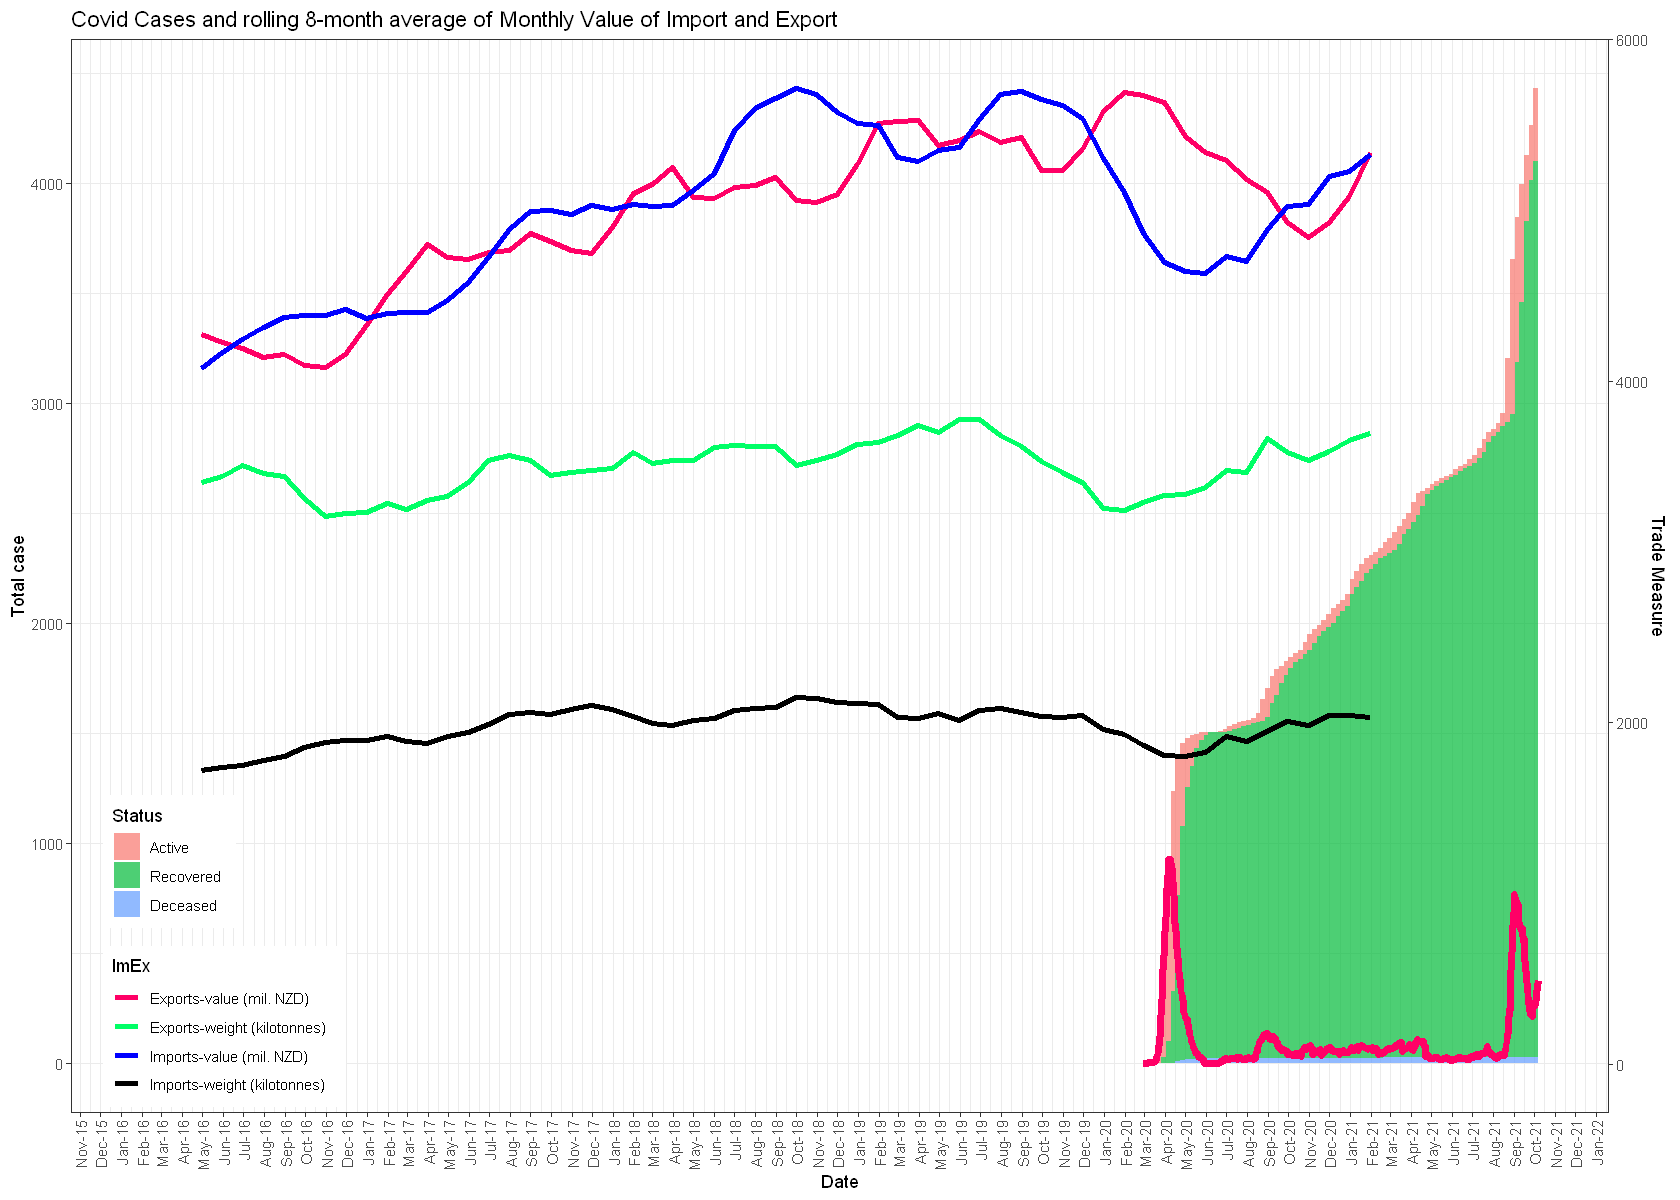

Warning message:
"Removed 6 rows containing missing values (position_stack)."
Warning message:
"Removed 14 row(s) containing missing values (geom_path)."
Warning message:
"Removed 14 row(s) containing missing values (geom_path)."
Warning message:
"Removed 6 rows containing missing values (position_stack)."


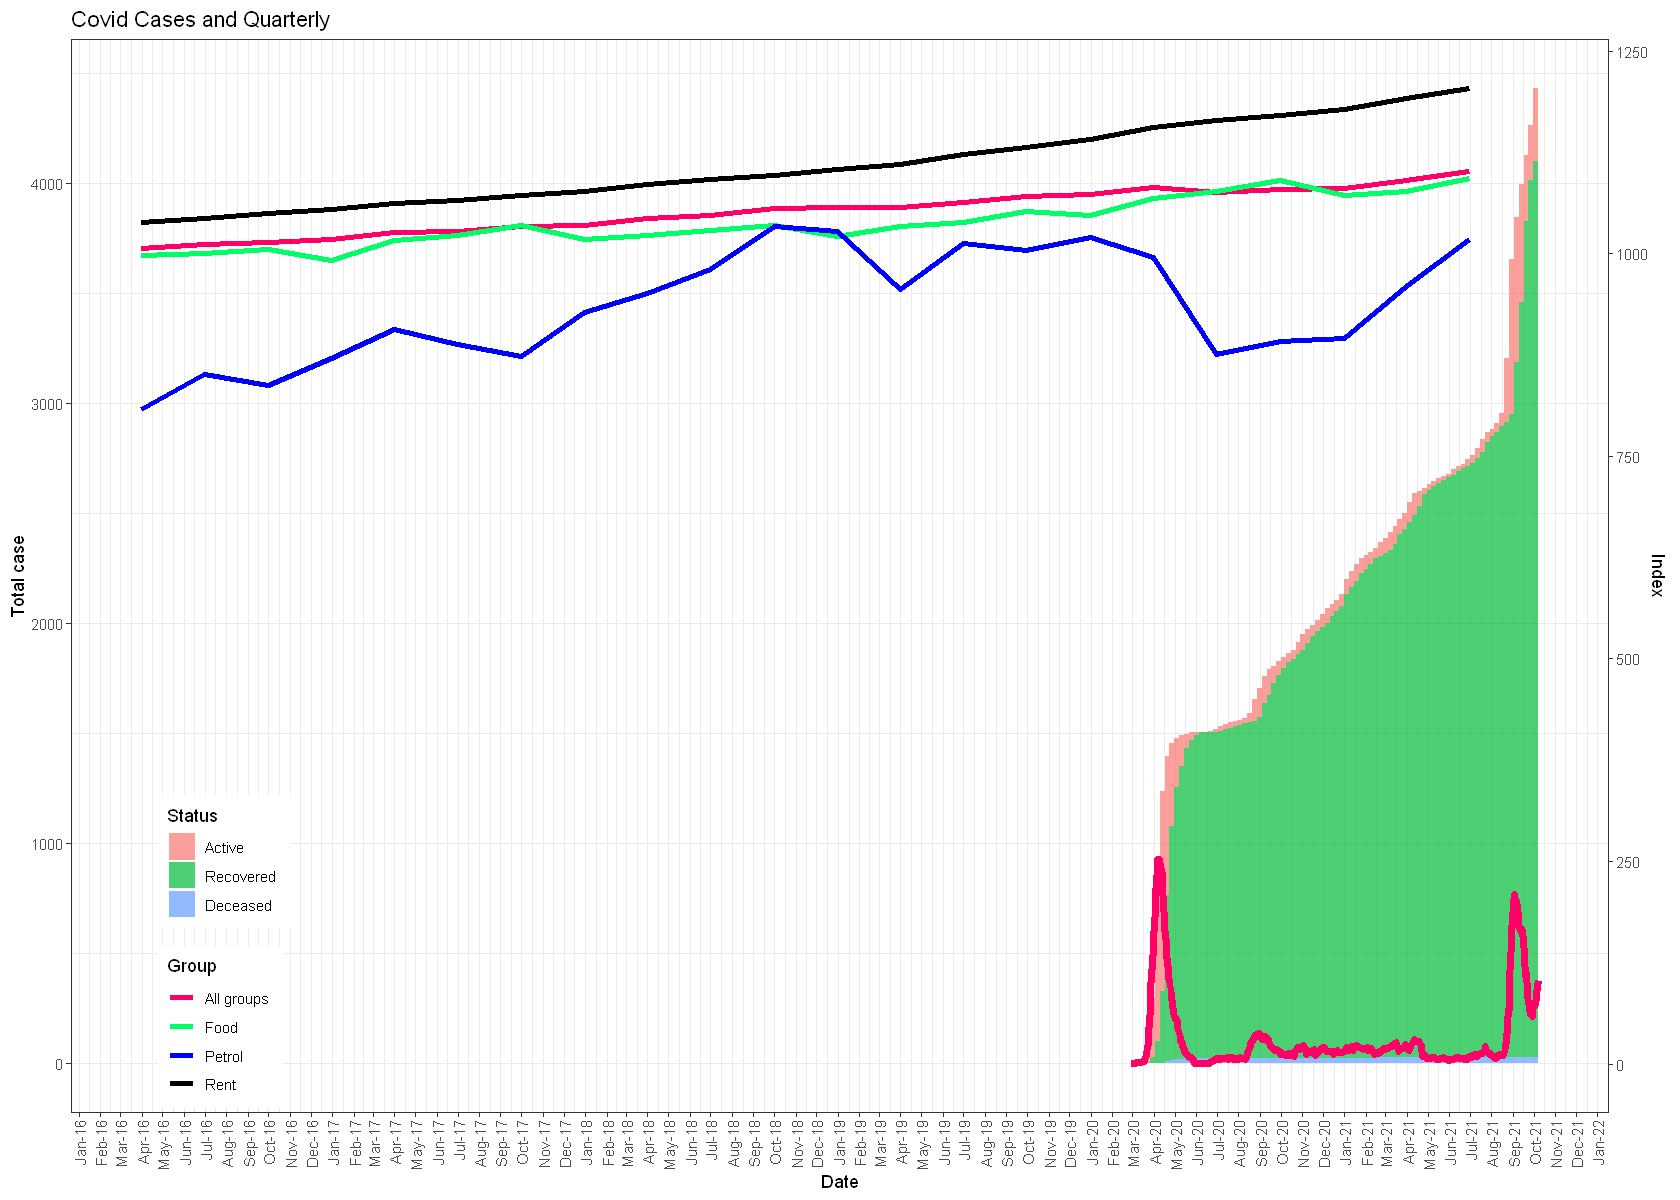

In [75]:
# Show Plots
covid_trade_plot
covid_cpi_plot

# Save Plots
savePlot("CombinedPlot_ImEx.png", covid_trade_plot)
savePlot("CombinedPlot_CPI.png", covid_cpi_plot)